<img src="images/crepmaker.png" width="600" align="left"/>

In [2]:
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


device(type='cuda')

## Step one: copping some clean kicks
I scraped images off [Flight Club](https://flightclub.com/) to use as training data. They're a sneaker retailer in New York that stock tons of sneakers but more importantly: they have great pics of their sneakers on their online store! So I obviously do not own any of the images, and the copyright belongs to Flight Club. Please don't sue me✌🏽.

The dataset consists of these photos, without any labels or metadata beyond the image data.

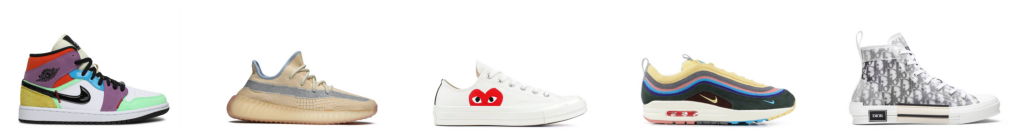

In [3]:
plt.figure(figsize=(18,7))
selected_kicks = [33, 59, 398, 104, 151]

for i in np.arange(1, 6):
    plt.subplot(1, 5, i)
    plt.axis('off')
    img = plt.imread('snkrs/0/{}.jpg'.format(selected_kicks[i-1]))
    plt.imshow(img)

In [71]:
IMG_WIDTH = 750
IMG_HEIGHT = 536
HIDDEN_DIM = 402000
LATENT_DIM = 20

img_transforms = transforms.Compose([
        transforms.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
        transforms.transforms.ToTensor(),
])

sneaker_dataset = datasets.ImageFolder(
        root='./snkrs',
        transform=img_transforms
)

sneaker_dataloader = DataLoader(
        sneaker_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=True
)

## Step two: VAE

In [74]:
class SneakerVAE(nn.Module):
    def __init__(self):
        super(SneakerVAE, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self.fc3 = nn.Linear(LATENT_DIM, HIDDEN_DIM)
        self.convT1 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.convT2 = nn.ConvTranspose2d(32, 3, kernel_size=5, padding=2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        batch_dim = x.shape[0]
        x = x.reshape([batch_dim, 64, -1])
        return self.fc1(x), self.fc2(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.convT1(z))
        return torch.sigmoid(self.convT2(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc3(z)
        batch_dim = z.shape[0]
        z = z.reshape([batch_dim, 64, IMG_HEIGHT, IMG_WIDTH])
        return self.decode(z), mu, logvar
    
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print('BCE: {}'.format(BCE))
    # print('KLD: {}'.format(KLD))
    # print()

    return BCE + KLD

    
sneaker_vae = SneakerVAE().to(device)
optimizer = optim.Adam(sneaker_vae.parameters(), lr=1e-3)

In [75]:
sneaker_vae.train()

for epoch in range(10):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(sneaker_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = sneaker_vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(sneaker_dataset),
                100. * batch_idx / len(sneaker_dataloader),
                loss.item() ))
    

    torch.save(sneaker_vae.state_dict, 'models/{}.pth'.format(epoch))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(sneaker_dataset)))

Train Epoch: 0 [0/939 (0%)]	Loss: 923360.187500
Train Epoch: 0 [50/939 (5%)]	Loss: 355670.750000
Train Epoch: 0 [100/939 (11%)]	Loss: 480617.187500
Train Epoch: 0 [150/939 (16%)]	Loss: 329215.125000
Train Epoch: 0 [200/939 (21%)]	Loss: 407083.468750
Train Epoch: 0 [250/939 (27%)]	Loss: 239784.484375
Train Epoch: 0 [300/939 (32%)]	Loss: 240288.250000
Train Epoch: 0 [350/939 (37%)]	Loss: 421776.875000
Train Epoch: 0 [400/939 (43%)]	Loss: 319031.093750
Train Epoch: 0 [450/939 (48%)]	Loss: 252933.875000
Train Epoch: 0 [500/939 (53%)]	Loss: 313207.875000
Train Epoch: 0 [550/939 (59%)]	Loss: 444263.562500
Train Epoch: 0 [600/939 (64%)]	Loss: 250099.187500
Train Epoch: 0 [650/939 (69%)]	Loss: 237686.796875
Train Epoch: 0 [700/939 (75%)]	Loss: 350047.375000
Train Epoch: 0 [750/939 (80%)]	Loss: 308329.031250
Train Epoch: 0 [800/939 (85%)]	Loss: 223645.953125
Train Epoch: 0 [850/939 (91%)]	Loss: 297689.781250
Train Epoch: 0 [900/939 (96%)]	Loss: 163778.375000
====> Epoch: 0 Average loss: 361667.

In [42]:
def test_image(idx):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Actual')
    plt.imshow(sneaker_dataset[idx][0].permute(1,2,0))
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Reconstructed')
    plt.imshow( sneaker_vae(sneaker_dataset[idx][0].unsqueeze(0).to(device))[0].detach().cpu().squeeze().permute(1,2,0).numpy() )

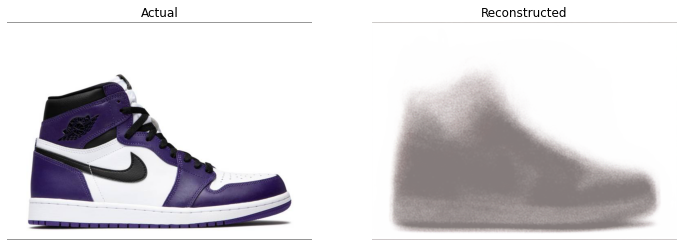

In [79]:
test_image(0)